# Compare TensorFlow RNN, ARIMA & Linear Regression Approaches

## Generate & Plot Test Data Set

Also do all the necessary imports.

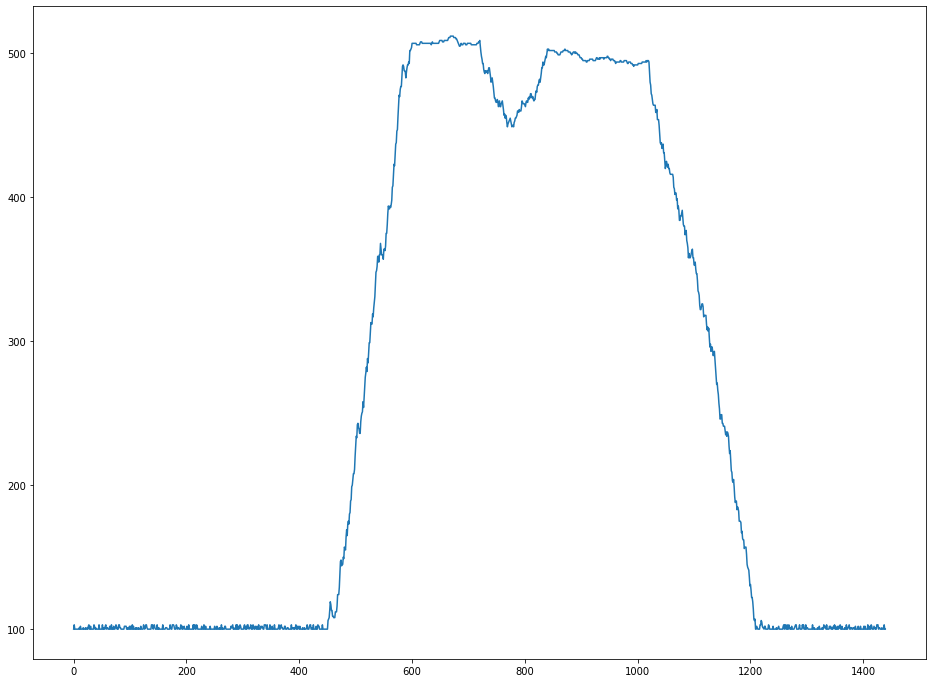

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tqdm import tqdm
import util

%matplotlib inline

mpl.rcParams['figure.figsize'] = (16, 12)
mpl.rcParams['axes.grid'] = False

# Number of days to generate data for
DAYS = 1

# generate a numpy array of raw data first
d = util.gen_data(days=DAYS)

# turn it into a pandas data frame
df = pd.DataFrame({'Time': d[:, 0], 'ACEs': d[:, 1]})

# plot just the ACEs series
plt.plot(df['ACEs'])

In [5]:
#
# plot raw data using bokeh as an alternative
#
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

p = figure()
p.line(x=df['Time'], y=df['ACEs'], color='blue')

show(p)

Loading BokehJS ...

## Loop over Data & Predict

100%|██████████| 1340/1340 [05:28<00:00,  4.08it/s]


Test MSE (ARIMA) : 5.421
Test MSE (LR)    : 6.412
Test MSE (RNN)   : 41.142


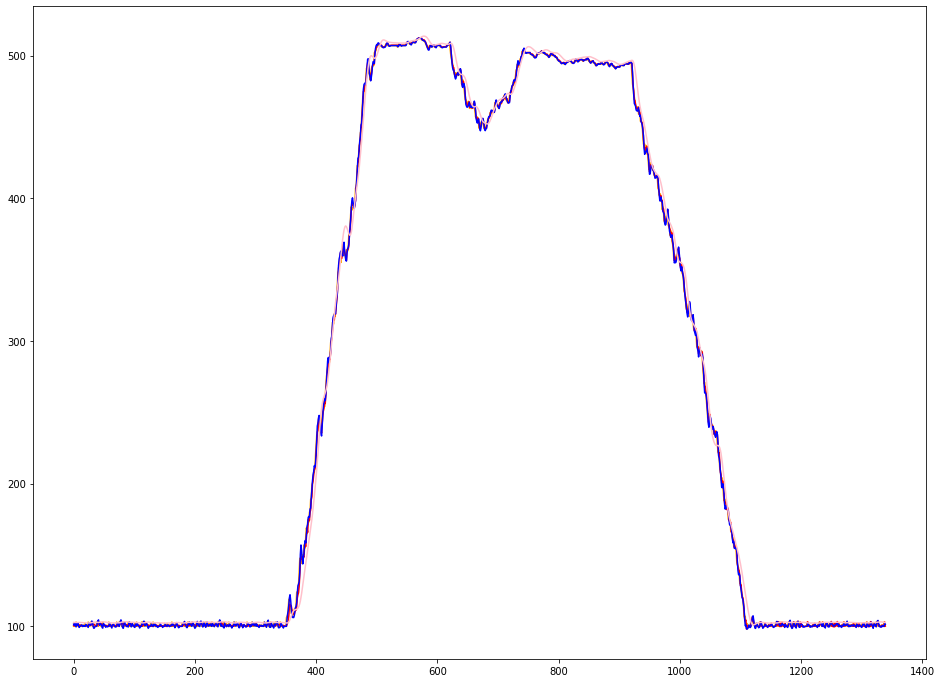

In [6]:
# number of historical data points to start with
HIST = 100

# number of historical datapoints to consider for LR & ARIMA
POINTS_ARIMA = 5
POINTS_LR = 5

x = [x for x in range(0, 1440)]
y = df['ACEs'].values

x_train, x_test = x[:HIST], x[HIST:]
y_train, y_test = y[:HIST], y[HIST:]
history = [h for h in y_train]
predictions_lr = list()
predictions_arima = list()
predictions_rnn = list()

# can just create a single LR "model"
model_lr = LinearRegression()


#
# create and compile an RNN model
#
BREADTH = 30
def create_model(breadth=BREADTH, input_shape=None):
    retval = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(BREADTH, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(BREADTH, return_sequences=True),
        tf.keras.layers.LSTM(BREADTH),
        tf.keras.layers.Dense(1)
    ])
    retval.compile(optimizer='adam', loss='mae')
    return retval

# instantiate a pre-trained RNN, including params for denormalization
TRAIN_MEAN = 246.65278472222224
TRAIN_STDDEV = 161.9523242418946
model_rnn = create_model(input_shape=(BREADTH, 1))
model_rnn.load_weights('save_lstm')

# loop over test array now
for t in tqdm(range(len(x_test))):
    
    # do ARIMA model & prediction
    model_arima = ARIMA(history, order=(POINTS_ARIMA, 1, 0))
    model_arima_fit = model_arima.fit(disp=0)
    output = model_arima_fit.forecast()
    yhat_ar = output[0]
    predictions_arima.append(yhat_ar)
    
    # do LR (TODO: this can be more efficient, probably by moving
    # stuff outside the loop!)
    x_arr = np.array(x[x_test[t]-POINTS_LR:x_test[t]]).reshape(-1, 1)
    y_arr = np.array(history[-POINTS_LR:]).reshape(-1, 1)
    model_lr.fit(x_arr, y_arr)
    yhat_lr = model_lr.intercept_ + (model_lr.coef_[0] * x_test[t])
    predictions_lr.append(yhat_lr)
    
    # do RNN prediction on last 30 data points
    y = np.array(history[-BREADTH:])
    y_arr = np.concatenate([np.roll(y, i) for i in range(0, 256)])
    y_arr = (y_arr - TRAIN_MEAN) / TRAIN_STDDEV
    y_arr = y_arr.reshape(-1, 30, 1)
    predictions_rnn.append(model_rnn.predict(y_arr)[0][0] * TRAIN_STDDEV + TRAIN_MEAN)
    
    # update history
    obs = y_test[t]
    history.append(obs)


error_arima = mean_squared_error(y_test, predictions_arima)
error_lr = mean_squared_error(y_test, predictions_lr)
error_rnn = mean_squared_error(y_test, predictions_rnn)

print('Test MSE (ARIMA) : %.3f' % error_arima)
print('Test MSE (LR)    : %.3f' % error_lr)
print('Test MSE (RNN)   : %.3f' % error_rnn)

plt.plot(history[HIST:], color='green')
plt.plot(predictions_arima, color='blue')
plt.plot(predictions_lr, color='orange')
plt.plot(predictions_rnn, color='red')
plt.show()

In [9]:
#
# plot same data using bokeh
#
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

p = figure(plot_width=900)

p.line(x=x[HIST:], y=history[HIST:], color='green')
p.line(x=x[HIST:], y=predictions_lr, color='blue')
p.line(x=x[HIST:], y=predictions_arima, color='orange')
p.line(x=x[HIST:], y=predictions_rnn, color='red')

show(p)

Loading BokehJS ...